In [143]:

import diamon_read_data as dia
import influx_data_query as idb
import numpy as np
import pandas as pd
import datetime
import pickle
import plotting as p
import importlib
import pytz
import diamon_analysis as da
from influx_data_utils.process_influx_data.datetime_localiser import \
    DatetimeLocaliser
importlib.reload(idb)
importlib.reload(da)
importlib.reload(p)
importlib.reload(dia)
ts2_path = r"C:\Users\sfs81547\OneDrive - Science and Technology Facilities Council\Documents\ISIS\Diamon Project\TS2 Measurements\DIAMON*"
location_path = r"C:\Users\sfs81547\OneDrive - Science and Technology Facilities Council\Documents\ISIS\Diamon Project\Code\data\Measurement_location.csv"
fname = "shutters_pickle.pkl"

In [2]:
#ONLY DO THIS ONCE!
def query_all_shutters(fname):
    importlib.reload(idb)
    start = datetime.datetime(2022,9,13)
    end = datetime.datetime(2022,12,16)
    shutters = dia.read_all_shutters(start, end)
    with open(fname, 'wb') as f:
        pickle.dump(shutters.data, f, protocol=pickle.HIGHEST_PROTOCOL)
    return

"importlib.reload(idb)\nstart = datetime.datetime(2022,9,13)\nend = datetime.datetime(2022,12,16)\nshutters = dia.read_all_shutters(start, end)\nwith open(fname, 'wb') as f:\n    pickle.dump(shutters.data, f, protocol=pickle.HIGHEST_PROTOCOL)"

In [134]:

data = da.load_data(ts2_path, location_path, "ts2")


In [142]:
importlib.reload(dia)
importlib.reload(da)
filtered_d = da.select_high_energy(data)
shutters = da.load_pickle(fname)
beam_data = {name: da.filter_beamline(data, name) for name in da.beamline_names()}
beam_df = {name: da.convert_to_df(beam) for name, beam in beam_data.items()}
shutter_dict = da.filter_shutter_status(beam_df, shutters)
filtered_d = da.convert_time_datetime(filtered_d)

#run once
#this finds rhe mean current for each measurement at each time interval diamon records for
mean_curr = {name: da.mean_curr_between_date(df, shutter_dict[name]["ts2_curr"]) for name, df in filtered_d.items()}

In [ ]:
"""#find average curent between measurement
if i == 0:
    start = shutter_dict["DIAMON-01_01.12.1"]["ts2_curr"]["_time"].values[0]
else:
    start = da.convert_date_to_string(data["DIAMON-01_01.12.1"]['out']['t(s)'].values[3])
end = da.convert_date_to_string(data["DIAMON-01_01.12.1"]['out']['t(s)'].values[4])
x = shutter_dict["DIAMON-01_01.12.1"]["ts2_curr"]
np.mean(x["_value"][x["_time"].between(start, end)])"""

36.51352134117713

In [20]:
for key in data.keys():
    if key in mean_curr:
        data[key]['out']["norm_dose"] = data[key]['out']['H*(10)r'] / (mean_curr[key])

In [66]:
""" #beam_df["chipir"]['start'].values[0].astype(str)
start = beam_df["chipir"]['start'].astype(str)
end =  beam_df["chipir"]['end'].astype(str)
current_df = shutters["ts2_current"]
print(type(start))
np.mean(shutters["ts2_current"]["_value"][current_df["_time"].between(start, end)])"""

<class 'pandas.core.series.Series'>


ValueError: Can only compare identically-labeled Series objects

In [130]:
#want to normalise dose by the integrated current over a measurement : dose/(avg_curr * overall_time)
for key, beam in beam_df.items():
    if not beam.empty:
        start = beam['start'].astype(str)
        end =  beam['end'].astype(str)
        curr = []
        curr_std = []
        for i, row in beam.iterrows():
            seconds  = (row['end'] - row['start']).total_seconds()
            curr.append(np.mean(shutters["ts2_current"]["_value"][shutters["ts2_current"]["_time"].between(start[0], end[0])] ) * seconds)
            curr_std.append(np.std(shutters["ts2_current"]["_value"][shutters["ts2_current"]["_time"].between(start[0], end[0])] ) * seconds)
        beam["integrated_current"] = curr
        beam["norm_dose_rate"] = beam["dose_rate"] / beam["integrated_current"]
        #beam["norm_dose_rate_uncert"] = beam["dose_rate_uncert"] / beam["integrated_current"]

In [128]:
#find beamline distance and sort by distance
for key, beamline in beam_df.items():
    if not beamline.empty:
        beamline = da.get_distance(beamline)
        beam_df[key] = beamline.sort_values("distance")

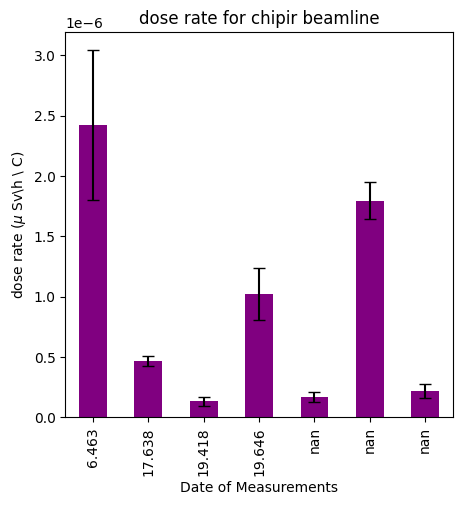

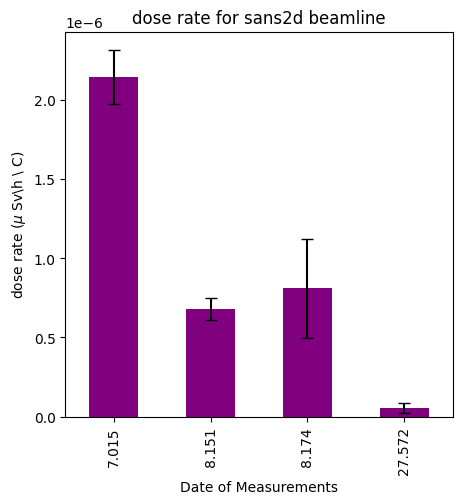

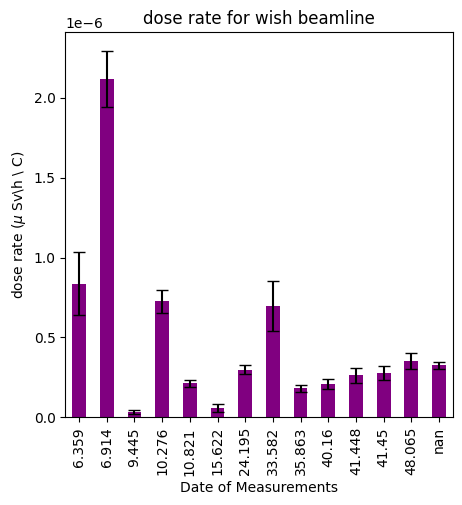

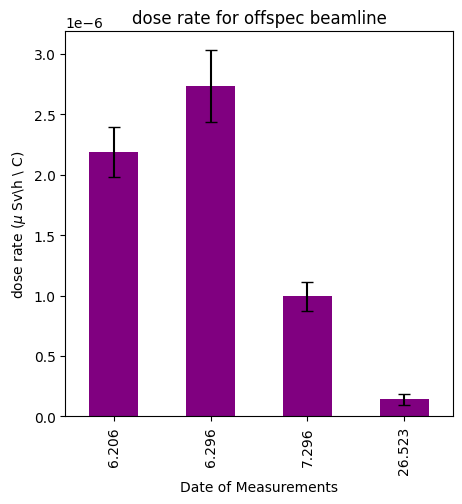

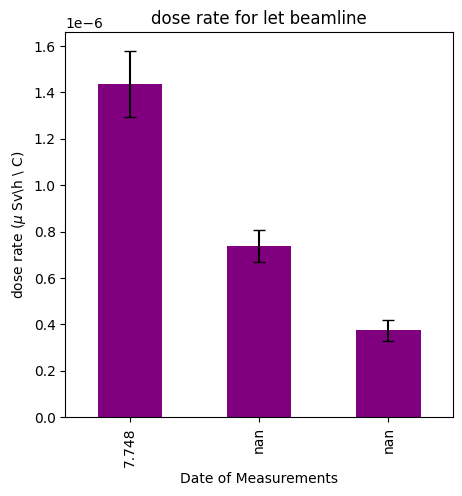

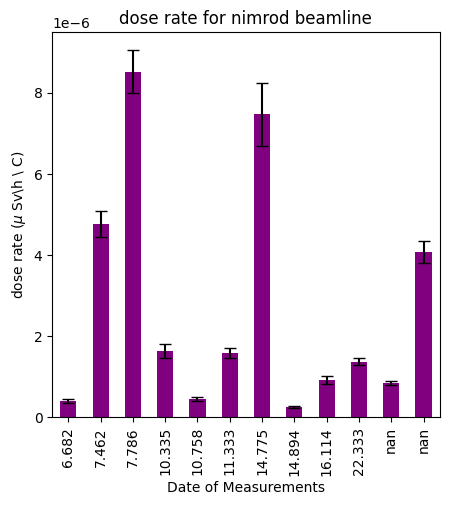

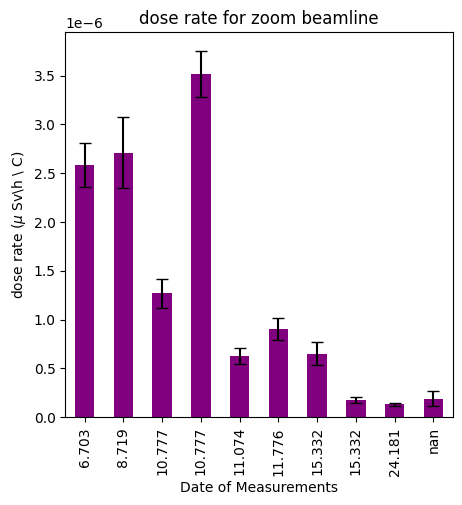

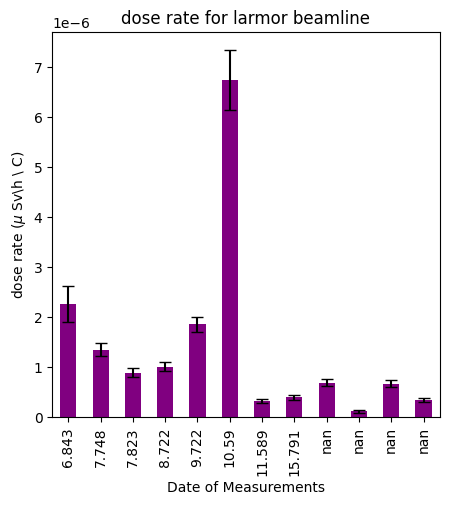

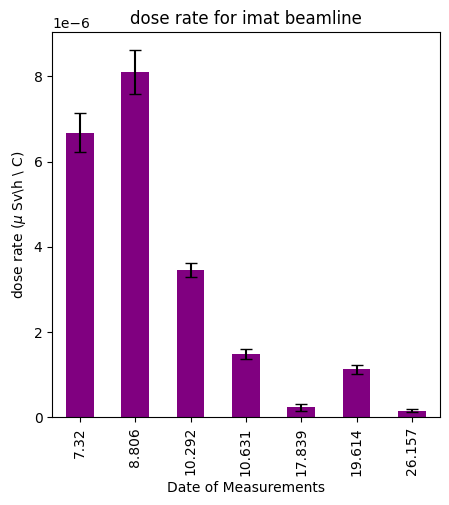

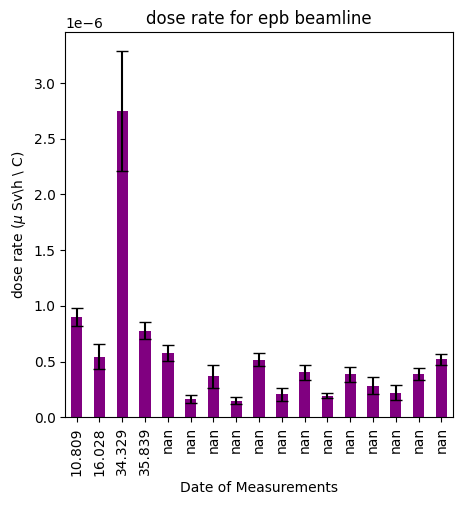

In [131]:
#plots - NEED ORDER THESE by distance away
importlib.reload(da)
importlib.reload(p)
for key, beamline in beam_df.items():
    if not beamline.empty:
        #p.plot_dose_distance(beamline, key)
        #p.plot_combined_spect(beamline, key)
        p.plot_dose_rate(beamline, key)
        #p.direction_bar_plot(beamline, key)
        #p.stack_bar_plot(beamline, key=key)


In [ ]:
beam_df['chipir']

,file_name,start,end,reference,x,y,z,dose_rate,dose_rate_uncert,dose_area_product,...,D6,F,FL,FR,R,RR,RL,energy_bins,flux_bins,distance
0,DIAMON-01_21.11.3,2022-11-21 14:21:57,2022-11-21 15:53:37.950,2CB-4,-3.561767,-5.3933,-6698.000,0.463,25.6,16.9,...,1051,2618,1974,1886,2199,2905,3096,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.02801912, 0.04556987, 0.07411146, 0.1187671...",6.463271
1,DIAMON-01_24.11.1,2022-11-29 14:37:16,2022-11-29 16:07:16.750,2CB-6,NaN,NaN,NaN,0.031,25.9,170.9,...,16,13,11,8,22,24,22,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[9.337002e-05, 0.0001518556, 0.0002469666, 0.0...",NaN
2,DIAMON-02_12.10.1,2022-10-12 08:17:00,2022-10-12 10:47:01.110,2CB-2,13.807000,10.9750,-6.945,0.145,8.7,44.1,...,290,637,404,497,340,600,492,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.002786347, 0.004531672, 0.007369974, 0.0118...",17.637570
3,DIAMON-02_24.11.1,2022-11-30 10:40:59,2022-11-30 12:12:39.830,2CB-7,NaN,NaN,NaN,0.343,8.6,36.7,...,605,1482,837,1207,456,1137,688,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.004360123, 0.007091237, 0.01153266, 0.01848...",NaN
4,DIAMON-03_12.10.2,2022-10-12 13:25:24,2022-10-12 14:25:24.550,2CB-1-1,NaN,NaN,NaN,0.027,25.6,102.7,...,13,21,13,27,15,17,14,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.0001099446, 0.0001788123, 0.000290807, 0.00...",NaN
5,DIAMON-03_17.11.1,2022-11-17 10:12:06,2022-11-17 11:43:47.230,2CB-3,17.646979,-8.1030,-7.498,0.025,27.5,161.4,...,10,11,17,15,16,18,18,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[8.039839e-05, 0.0001307587, 0.0002126563, 0.0...",19.418406
6,DIAMON-03_21.11.3,2022-11-21 14:23:01,2022-11-21 15:54:42.290,2CB-5,-9.827410,-17.0110,-7.498,0.195,21.0,25.9,...,337,742,546,601,723,894,946,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.00665318, 0.01082063, 0.01759787, 0.0282014...",19.645664


In [ ]:
beam_df["chipir"]

,file_name,start,end,reference,x,y,z,dose_rate,dose_rate_uncert,dose_area_product,...,D6,F,FL,FR,R,RR,RL,energy_bins,flux_bins,distance
0,DIAMON-01_21.11.3,2022-11-21 14:21:57,2022-11-21 15:53:37.950,2CB-4,-3.561767,-5.3933,-6698.000,0.463,25.6,16.9,...,1051,2618,1974,1886,2199,2905,3096,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.02801912, 0.04556987, 0.07411146, 0.1187671...",6.463271
1,DIAMON-01_24.11.1,2022-11-29 14:37:16,2022-11-29 16:07:16.750,2CB-6,NaN,NaN,NaN,0.031,25.9,170.9,...,16,13,11,8,22,24,22,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[9.337002e-05, 0.0001518556, 0.0002469666, 0.0...",NaN
2,DIAMON-02_12.10.1,2022-10-12 08:17:00,2022-10-12 10:47:01.110,2CB-2,13.807000,10.9750,-6.945,0.145,8.7,44.1,...,290,637,404,497,340,600,492,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.002786347, 0.004531672, 0.007369974, 0.0118...",17.637570
3,DIAMON-02_24.11.1,2022-11-30 10:40:59,2022-11-30 12:12:39.830,2CB-7,NaN,NaN,NaN,0.343,8.6,36.7,...,605,1482,837,1207,456,1137,688,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.004360123, 0.007091237, 0.01153266, 0.01848...",NaN
4,DIAMON-03_12.10.2,2022-10-12 13:25:24,2022-10-12 14:25:24.550,2CB-1-1,NaN,NaN,NaN,0.027,25.6,102.7,...,13,21,13,27,15,17,14,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.0001099446, 0.0001788123, 0.000290807, 0.00...",NaN
5,DIAMON-03_17.11.1,2022-11-17 10:12:06,2022-11-17 11:43:47.230,2CB-3,17.646979,-8.1030,-7.498,0.025,27.5,161.4,...,10,11,17,15,16,18,18,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[8.039839e-05, 0.0001307587, 0.0002126563, 0.0...",19.418406
6,DIAMON-03_21.11.3,2022-11-21 14:23:01,2022-11-21 15:54:42.290,2CB-5,-9.827410,-17.0110,-7.498,0.195,21.0,25.9,...,337,742,546,601,723,894,946,"[2e-09, 2.58e-09, 3.34e-09, 4.31e-09, 5.57e-09...","[0.00665318, 0.01082063, 0.01759787, 0.0282014...",19.645664
